[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jeyabbalas/py-icare/blob/master/examples/Python/Model%20validation.ipynb)

# Model validation

In this example, we will demonstrate the use of iCARE to validate an absolute risk model on an independent cohort that was not used for model building. Using simulated data, we will evaluate a risk model containing both classical risk factors and SNPs. iCARE can be used for validating on either a cohort study dataset or a dataset from a case-control study nested within a cohort study. We will demonstrate the latter use-case here because it involves a few more steps than evaluating on a cohort study. Throughout the notebook, we will comment on how to validate on cohort study data differently than the nested case-control data scenario.

In [ ]:
! pip install icare --quiet

In [1]:
import json
import pathlib

import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

import icare


# Set the plot background to white
sns.set(style="whitegrid", rc={"axes.facecolor": "white", "grid.color": "white"})
seed = 1234

We have provided an example, simulated cohort study data at: [`validation_cohort_data.csv`](https://github.com/jeyabbalas/py-icare/blob/master/data/validation_cohort_data.csv). There are 50,000 women in this dataset with information on their: the classical risk factors (`family_history`, `age_at_menarche`, `parity`, `age_at_first_child_birth`, `age_at_menopause`, `height`, `bmi`, `menopause_hrt`, `menopause_hrt_e`, `menopause_hrt_c`, `current_hrt`, `alcohol_consumption`, `smoking_status`), age at study entry (`study_entry_age`), age at study exit (`study_exit_age`), disease status (`observed_outcome`), and time to disease onset (`time_of_onset`). We have also provided an `inclusion` variable that indicates if the individual was included in the subsequent nested case-control study. This is a common scenario in modern cohort studies, where expensive markers such as genetic factors are not measured for all the individuals in the cohort, but only for a judiciously selected sub-sample. These individuals compose the nested case-control dataset provided at: [`validation_nested_case_control_data.csv`](https://github.com/jeyabbalas/py-icare/blob/master/data/validation_nested_case_control_data.csv). This dataset consists of 5,285 women with information on: the classical risk factors measured during the earlier phase of the cohort study, age at study entry (`study_entry_age`), age at study exit (`study_exit_age`), disease status (`observed_outcome`), time to disease onset (`time_of_onset`), and additionally 72 breast cancer-associated SNPs that were not measured for the rest of the individuals in the cohort study. We will use this nested case-control study dataset to validate our absolute risk model.

The dependencies for building the iCARE model that is being validated is similar to the notebooks describing how to build and apply absolute risk models using iCARE. To specify a covariate model in iCARE, we need to provide: 1) a text file containing the covariate model formula description using the [Patsy formula language](https://patsy.readthedocs.io/en/latest/formulas.html) (`model_covariate_formula_path`), 2) the breast cancer log odds ratios associated with each risk factor in the covariate model (`model_log_relative_risk_path`), 3) a reference dataset describing the distribution of the classical risk factors in the underlying population (`model_reference_dataset_path`), 4) a set of profiles, specifying the classical risk factors of individuals for whom, the absolute risk is to be estimated (`apply_covariate_profile_path`), 5) the marginal age-specific incidence rates of breast cancer (`model_disease_incidence_rates_path`), and 6) optionally, the age-specific incidence rates of competing risks (`model_competing_incidence_rates_path`). We include them in this example.

To specify a SNP model using the special option, we must additionally input files containing: 1) the SNP information (`model_snp_info_path`), that has three columns named `snp_name`, `snp_odds_ratio`, and `snp_freq` corresponding to the SNP name, their odds ratios in association with breast cancer risk, and their minor allele frequencies, respectively, and 2) a set of profiles, specifying the SNPs of individuals (same as those specified in the covariate profile) for whom, the absolute risk is to be estimated (`apply_snp_profile_path`).

The covariate model described in the file specified below is based on a logistic regression model adjusted for cohort and fine categories of age in the Breast and Prostate Cancer Cohort Consortium ([Campa et al. 2011](https://pubmed.ncbi.nlm.nih.gov/21791674/), [Joshi et al. 2014](https://pubmed.ncbi.nlm.nih.gov/25255808/), and [Maas et al. 2016](https://pubmed.ncbi.nlm.nih.gov/27228256/)). The reference dataset was created by simulation from [the National Health Interview Survey (NHIS)](ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Dataset_Documentation/NHIS/2010/srvydesc.pdf) and [the National Health and Nutrition Examination Survey (NHANES)](https://wwwn.cdc.gov/nchs/nhanes/default.aspx), which are representative of the US population. `breast_cancer_72_snps_info.csv` contains published information on the odds-ratios and allele frequencies of 72 SNPs identified, among a larger set of markers, to be associated with breast cancer risk by [a recent genome-wide association study](https://www.nature.com/articles/nature24284) (Michailidou et al., 2017). `age_specific_breast_cancer_incidence_rates.csv` contains age-specific incidence rates of breast cancer from [Surveillance, Epidemiology and End Results (SEER) Program](https://seer.cancer.gov/), and `age_specific_all_cause_mortality_rates.csv` has age-specific incidence rates of all-cause mortality from [the CDC WONDER database](https://wonder.cdc.gov/). We indicate `model_family_history_variable_name = "family_history"` to allow the software to properly attenuate the log odds ratio for family history to account for the addition of the 72 SNPs.

In [2]:
# Data files URLs
github_source = "https://raw.githubusercontent.com/jeyabbalas/py-icare/master/data/"

validation_cohort_data_url = github_source + "validation_cohort_data.csv"
validation_nested_case_control_data_url = github_source + "validation_nested_case_control_data.csv"

model_covariate_formula_url = github_source + "breast_cancer_covariate_model_formula.txt"
model_log_relative_risk_url = github_source + "breast_cancer_model_log_odds_ratios.json"
model_reference_dataset_url = github_source + "reference_covariate_data.csv"
model_snp_info_url = github_source + "breast_cancer_72_snps_info.csv"
model_disease_incidence_rates_url = github_source + "age_specific_breast_cancer_incidence_rates.csv"
model_competing_incidence_rates_url = github_source + "age_specific_all_cause_mortality_rates.csv"

In [3]:
# Data will be downloaded here
data_dir = pathlib.Path("data")
data_dir.mkdir(exist_ok=True)

validation_cohort_data_path = data_dir / "validation_cohort_data.csv"
validation_nested_case_control_data_path = data_dir / "validation_nested_case_control_data.csv"

model_covariate_formula_path = data_dir / "breast_cancer_covariate_model_formula.txt"
model_log_relative_risk_path = data_dir / "breast_cancer_model_log_odds_ratios.json"
model_reference_dataset_path = data_dir / "reference_covariate_data.csv"
model_snp_info_path = data_dir / "breast_cancer_72_snps_info.csv"
model_disease_incidence_rates_path = data_dir / "age_specific_breast_cancer_incidence_rates.csv"
model_competing_incidence_rates_path = data_dir / "age_specific_all_cause_mortality_rates.csv"

In [4]:
for url, path in zip(
    [
        validation_cohort_data_url,
        validation_nested_case_control_data_url,
        model_covariate_formula_url,
        model_log_relative_risk_url,
        model_reference_dataset_url,
        model_snp_info_url,
        model_disease_incidence_rates_url,
        model_competing_incidence_rates_url,
    ],
    [
        validation_cohort_data_path,
        validation_nested_case_control_data_path,
        model_covariate_formula_path,
        model_log_relative_risk_path,
        model_reference_dataset_path,
        model_snp_info_path,
        model_disease_incidence_rates_path,
        model_competing_incidence_rates_path,
    ],
):
    print(f"Downloading {url} to {path}")
    response = requests.get(url)
    response.raise_for_status()
    with open(path, "wb") as f:
        f.write(response.content)

The provided nested case-control study dataset contains an additional variable, `sampling_weights`, which is the probability that the individual was included in the nested case-control study from the cohort study. This variable is required for model validation using nested case-control study data because the calibration and discrimination statistics need to be adjusted for non-random sampling using the sampling weights.

Note that if you were working with a cohort study data instead of a nested case-control study data, you don't need to provide sampling weights. So, the steps until the sub-heading 'Model validation' should be skipped.

In [5]:
validation_nested_case_control_data = pd.read_csv(
    validation_nested_case_control_data_path
).set_index("id")
validation_nested_case_control_data["sampling_weights"].head()

id
12    0.542398
31    0.095349
32    0.097969
58    0.143073
64    0.108129
Name: sampling_weights, dtype: float64

However, the `sampling_weights` may not always be available. In this notebook, we assume that this variable is not available, and we will show you how to calculate it from the cohort study dataset. When sampling weights are not provided, we recommend using a post-hoc estimation by assuming parametric models for the selection mechanism. We illustrate the sampling weight calculation through a logistic regression model of inclusion on disease status, age of study entry, observed follow-up, and an interaction of disease status with age at study entry and observed follow-up.

In [6]:
# drop the sampling_weights variable to show the scenario where it is not available
validation_nested_case_control_data = validation_nested_case_control_data.drop(
    columns=["sampling_weights"]
)
validation_nested_case_control_data.head()

,family_history,age_at_menarche,parity,age_at_first_child_birth,age_at_menopause,height,bmi,menopause_hrt,menopause_hrt_e,menopause_hrt_c,...,rs3760982,rs2284378,rs2823093,rs17879961,rs132390,rs6001930,study_entry_age,study_exit_age,observed_outcome,time_of_onset
id,,,,,,,,,,,,,,,,,,,,,
12,1,13-14,>=4,30-34,53-55,1.61-1.63,>=34.6,1,0,0,...,0,0,1,0,0,0,67,73,1,0.012103
31,0,12-13,0,<=19,>=55,1.66-1.68,23-24.2,2,0,1,...,2,0,2,0,0,0,70,77,0,inf
32,0,12-13,2,<=19,40-45,1.63-1.65,31.4-34.6,1,0,1,...,0,1,1,0,1,1,64,74,0,inf
58,0,11-11.5,2,27-30,48-50,1.63-1.65,27.8-29.3,1,0,0,...,1,1,2,0,0,0,66,79,0,inf
64,0,13-14,3,<=19,48-50,1.65-1.66,29.3-31.4,2,1,0,...,1,2,0,0,0,0,64,75,0,inf


In [7]:
validation_cohort_data = pd.read_csv(validation_cohort_data_path).set_index("id")
# assuming that the follow inclusion indicator and observed follow-up variables are not available
validation_cohort_data = validation_cohort_data.drop(columns=["inclusion", "observed_followup"])
validation_cohort_data.head()

,family_history,age_at_menarche,parity,age_at_first_child_birth,age_at_menopause,height,bmi,menopause_hrt,menopause_hrt_e,menopause_hrt_c,current_hrt,alcohol_consumption,smoking_status,study_entry_age,study_exit_age,observed_outcome,time_of_onset
id,,,,,,,,,,,,,,,,,
1,0,13-14,0,19-22,40-45,1.63-1.65,>=34.6,1,0,0,0,none,ever,61,68,0,inf
2,0,>=15,0,19-22,<=40,1.63-1.65,24.2-25.3,1,0,0,0,0.8-1.5,never,57,70,0,inf
3,0,<=11,0,<=19,51-52,<=1.55,>=34.6,1,0,0,0,none,ever,58,71,0,inf
4,0,13-14,2,27-30,48-50,1.61-1.63,25.3-26.5,2,0,0,0,1.5-3.2,never,65,71,0,inf
5,0,13-14,2,30-34,<=40,1.60-1.61,31.4-34.6,2,0,0,0,none,never,53,66,0,inf


The first step is to identify the subjects in the full cohort who are included in the nested sub-sample through matching of subject identifiers and create the indicator of inclusion.

In [8]:
validation_cohort_data["inclusion"] = validation_cohort_data.index.isin(
    validation_nested_case_control_data.index
).astype(int)
validation_cohort_data["inclusion"].head()

id
1    0
2    0
3    0
4    0
5    0
Name: inclusion, dtype: int64

Next, we calculate the observed follow-up time as the time between `study_entry_age` and `study_exit_age`.

In [9]:
validation_cohort_data["observed_followup"] = (
    validation_cohort_data["study_exit_age"] - validation_cohort_data["study_entry_age"]
)
validation_cohort_data["observed_followup"].head()

id
1     7
2    13
3    13
4     6
5    13
Name: observed_followup, dtype: int64

The next step is to fit a logistic regression model of inclusion based on disease status, age of study entry, observed follow-up, and an interaction of disease status with age at study entry and observed follow-up. We will use the `statsmodels` package to fit this model.

In [10]:
selection_model = smf.glm('inclusion ~ observed_outcome * (study_entry_age + observed_followup)',
                          data = validation_cohort_data,
                          family = sm.families.Binomial(link=sm.families.links.Logit())).fit()

In [11]:
validation_nested_case_control_data['sampling_weights'] = selection_model.fittedvalues[validation_cohort_data["inclusion"] == 1]

In [12]:
validation_nested_case_control_data['sampling_weights'].head()

id
12    0.592881
31    0.095922
32    0.099126
58    0.145702
64    0.109644
Name: sampling_weights, dtype: float64

We have now recovered the sampling weights for the nested case-control study data. We can now proceed with the model validation. Let us save our data to a file. Here, we will overwrite the existing file.

In [13]:
validation_cohort_data.to_csv(validation_cohort_data_path)
validation_nested_case_control_data.to_csv(validation_nested_case_control_data_path)

We will separate out the covariate data from the nested case-control study data and save it into separate files. We do this because we will build an absolute risk model using iCARE (the model being validated), where we have the reference dataset for our covariates but not for SNPs. So, we will make use of the special SNP option there. If we have the reference dataset for SNPs, we don't need to do this.

In [14]:
covariate_columns = [
    "family_history", "age_at_menarche", "parity", "age_at_first_child_birth",
    "age_at_menopause", "height", "bmi", "menopause_hrt",
    "menopause_hrt_e", "menopause_hrt_c", "current_hrt", "alcohol_consumption",
    "smoking_status"
]

snp_columns = [
    "rs616488", "rs11552449", "rs11249433", "rs12405132", "rs12048493",
    "rs6678914", "rs4245739", "rs72755295", "rs12710696", "rs4849887",
    "rs2016394", "rs1550623", "rs16857609", "rs6762644", "rs4973768",
    "rs12493607", "rs6796502", "rs9790517", "rs6828523", "rs10069690",
    "rs13162653", "rs2012709", "rs10941679", "rs10472076", "rs1353747",
    "rs7707921", "rs1432679", "rs11242675", "rs204247", "rs9257408",
    "rs4593472", "rs720475", "rs9693444", "rs13365225", "rs6472903",
    "rs2943559", "rs13267382", "rs11780156", "rs1011970", "rs10759243",
    "rs2380205", "rs7072776", "rs11814448", "rs7904519", "rs11199914",
    "rs554219", "rs75915166", "rs11820646", "rs12422552", "rs17356907",
    "rs1292011", "rs11571833", "rs2236007", "rs2588809", "rs999737",
    "rs941764", "rs11627032", "rs17817449", "rs11075995", "rs13329835",
    "rs146699004", "rs745570", "rs527616", "rs1436904", "rs6507583",
    "rs4808801", "rs3760982", "rs2284378", "rs2823093", "rs17879961",
    "rs132390", "rs6001930"
]

In [15]:
apply_covariate_profile_path = data_dir / "validation_nested_case_control_covariate_data.csv"
apply_snp_profile_path = data_dir / "validation_nested_case_control_snp_data.csv"

validation_nested_case_control_data[covariate_columns].to_csv(apply_covariate_profile_path)
validation_nested_case_control_data[snp_columns].to_csv(apply_snp_profile_path)

## Model validation

We will specify the absolute risk model, being validated, using a dictionary. The parameters of the iCARE model to be built is specified using a single parameter in the `validate_absolute_risk_model()` method. The model specifications as shown below.

In [16]:
icare_model_parameters = {
    "apply_age_start": 50,
    "apply_age_interval_length": 30,  # age end is 50 + 30 = 80
    "model_covariate_formula_path": model_covariate_formula_path,
    "model_log_relative_risk_path": model_log_relative_risk_path,
    "model_reference_dataset_path": model_reference_dataset_path,
    "model_snp_info_path": model_snp_info_path,
    "model_family_history_variable_name": "family_history",
    "model_disease_incidence_rates_path": model_disease_incidence_rates_path,
    "model_competing_incidence_rates_path": model_competing_incidence_rates_path,
    "apply_covariate_profile_path": apply_covariate_profile_path,
    "apply_snp_profile_path": apply_snp_profile_path,
    "seed": seed
}

We can configure the model validation using the parameters below.

In [17]:
study_data_path = validation_nested_case_control_data_path
predicted_risk_interval = "total-followup"
predicted_risk_variable_name = None  # not pre-specifying because we will build iCARE and calculate risks
linear_predictor_variable_name = None  # not pre-specifying because we will build iCARE and calculate linear predictors
reference_entry_age = None
reference_exit_age = None
reference_predicted_risks = None
reference_linear_predictors = None
number_of_percentiles = 10
linear_predictor_cutoffs = None
dataset_name = "Example dataset"
model_name = "Example model"

In [18]:
results = icare.validate_absolute_risk_model(
    study_data_path=study_data_path,
    predicted_risk_interval=predicted_risk_interval,
    icare_model_parameters=icare_model_parameters,
    predicted_risk_variable_name=predicted_risk_variable_name,
    linear_predictor_variable_name=linear_predictor_variable_name,
    reference_entry_age=reference_entry_age,
    reference_exit_age=reference_exit_age,
    reference_predicted_risks=reference_predicted_risks,
    reference_linear_predictors=reference_linear_predictors,
    number_of_percentiles=number_of_percentiles,
    linear_predictor_cutoffs=linear_predictor_cutoffs,
    dataset_name=dataset_name,
    model_name=model_name,
    seed=seed
)


Note: Both 'predicted_risk_variable_name' and 'linear_predictor_variable_name' were not provided. They will be calculated using iCARE.


The method returns a dictionary containing the following keys:

In [19]:
results.keys()

dict_keys(['info', 'study_data', 'incidence_rates', 'auc', 'expected_by_observed_ratio', 'calibration', 'category_specific_calibration', 'method'])

The `method` key contains the name of the iCARE method used:

In [20]:
print(f"iCARE method used: {results['method']}")

iCARE method used: iCARE - absolute risk model validation


Information about the model validation run.

In [21]:
info = results['info']
print(json.dumps(info, indent=4))

{
    "dataset_name": "Example dataset",
    "model_name": "Example model",
    "risk_prediction_interval": "Observed follow-up"
}


The original study data including new columns generated by this method for: 1) `predicted_risk_interval`, risk prediction interval for each individual; 2) `followup`, observed follow-up; 3) `risk_estimates`, calculated absolute risk by iCARE model built using the parameters specified above; 4) `linear_predictors`, calculated linear predictors by iCARE model built using the parameters specified above; 5) `linear_predictors_category`, quantile bins generated for calculating the calibration metrics.

In [22]:
study_data = pd.read_json(results['study_data'])
study_data = study_data.set_index('id')
study_data.head()

,family_history,age_at_menarche,parity,age_at_first_child_birth,age_at_menopause,height,bmi,menopause_hrt,menopause_hrt_e,menopause_hrt_c,...,observed_outcome,time_of_onset,sampling_weights,frequency,observed_followup,predicted_risk_interval,followup,risk_estimates,linear_predictors,linear_predictors_category
id,,,,,,,,,,,,,,,,,,,,,
12,1,13-14,>=4,30-34,53-55,1.61-1.63,>=34.6,1,0,0,...,1,0.012103,0.592881,1.686678,6,6,6,0.064757,1.226318,"{'closed': 'right', 'closed_left': False, 'clo..."
31,0,12-13,0,<=19,>=55,1.66-1.68,23-24.2,2,0,1,...,0,NaN,0.095922,10.425110,7,7,7,0.047767,0.753181,"{'closed': 'right', 'closed_left': False, 'clo..."
32,0,12-13,2,<=19,40-45,1.63-1.65,31.4-34.6,1,0,1,...,0,NaN,0.099126,10.088217,10,10,10,0.071784,0.854727,"{'closed': 'right', 'closed_left': False, 'clo..."
58,0,11-11.5,2,27-30,48-50,1.63-1.65,27.8-29.3,1,0,0,...,0,NaN,0.145702,6.863340,13,13,13,0.089169,0.828400,"{'closed': 'right', 'closed_left': False, 'clo..."
64,0,13-14,3,<=19,48-50,1.65-1.66,29.3-31.4,2,1,0,...,0,NaN,0.109644,9.120410,11,11,11,0.056640,0.519297,"{'closed': 'right', 'closed_left': False, 'clo..."


The estimated age-specific incidence rates.

In [23]:
incidence_rates = pd.read_json(results['incidence_rates'])
incidence_rates = incidence_rates.set_index('age')
incidence_rates.loc[51:56]

,population_rate,study_rate
age,,
51,0.002270,0.004239
52,0.002374,0.002484
53,0.002489,0.001891
54,0.002541,0.004182
55,0.002600,0.003417
56,0.002771,0.003893


Model discrimination capability calculated using the area under the receiver operating characteristic curve (AUC).

In [24]:
auc = results['auc']
print(json.dumps(auc, indent=4))

{
    "auc": 0.5916905045685857,
    "variance": 8.988073855064069e-05,
    "lower_ci": 0.5731086358461956,
    "upper_ci": 0.6102723732909758
}


The ratio of the expected and the observed number of cases in the study.

In [25]:
expected_by_observed_ratio = results['expected_by_observed_ratio']
print(json.dumps(expected_by_observed_ratio, indent=4))

{
    "ratio": 0.9691788106037985,
    "lower_ci": 0.9102096625001854,
    "upper_ci": 1.031968353690381
}


Model calibration performance.

In [26]:
calibration = results['calibration']
print(json.dumps(calibration, indent=4))

{
    "absolute_risk": {
        "method": "Hosmer\u2013Lemeshow goodness of fit (GOF) test for Absolute Risk",
        "p_value": 0.0013092776869355616,
        "variance": [
            [
                6.115796516347666e-06,
                0.0,
                0.0,
                0.0,
                0.0,
                0.0,
                0.0,
                0.0,
                0.0,
                0.0
            ],
            [
                0.0,
                8.610757678318331e-06,
                0.0,
                0.0,
                0.0,
                0.0,
                0.0,
                0.0,
                0.0,
                0.0
            ],
            [
                0.0,
                0.0,
                8.163513683003277e-06,
                0.0,
                0.0,
                0.0,
                0.0,
                0.0,
                0.0,
                0.0
            ],
            [
                0.0,
                0.0,


Category-specific calibration results.

In [27]:
category_specific_calibration = pd.read_json(results['category_specific_calibration'])
category_specific_calibration = category_specific_calibration.set_index('category')
category_specific_calibration.head()

,observed_absolute_risk,predicted_absolute_risk,lower_ci_absolute_risk,upper_ci_absolute_risk,observed_relative_risk,predicted_relative_risk,lower_ci_relative_risk,upper_ci_relative_risk
category,,,,,,,,
"(-1.462, -0.371]",0.020303,0.014367,0.015456,0.025150,0.592296,0.432519,0.469196,0.747694
"(-0.371, -0.185]",0.028261,0.019598,0.022509,0.034012,0.824461,0.589979,0.677356,1.003513
"(-0.185, -0.0552]",0.025613,0.022342,0.020013,0.031213,0.747215,0.672594,0.604823,0.923130
"(-0.0552, 0.0606]",0.025025,0.024468,0.019392,0.030658,0.730068,0.736580,0.587362,0.907447
"(0.0606, 0.176]",0.026821,0.027974,0.020893,0.032748,0.782445,0.842143,0.632532,0.967889


## Visualizing the results

Let us generate a summary report of some of the most important metrics calculated during model validation.

In [28]:
print("Validation results\n==================\n")

print(f"Dataset name: {info['dataset_name']}")
print(f"Model name: {info['model_name']}")
print(f"Risk prediction interval: {info['risk_prediction_interval']}")
print(f"Number of subjects (cases): {len(study_data)} ({len(study_data[study_data['observed_outcome'] == 1])})")
print(f"Follow-up time (years) [mean, range]: [{study_data['followup'].mean():.3f}, ({study_data['followup'].min()}, {study_data['followup'].max()})]")
print(f"Baseline age (years) [mean, range]: [{study_data['study_entry_age'].mean():.3f}, ({study_data['study_entry_age'].min()}, {study_data['study_entry_age'].max()})]")
print(f"E/O [estimate, 95% CI]: {expected_by_observed_ratio['ratio']:.3f} ({expected_by_observed_ratio['lower_ci']:.3f}, {expected_by_observed_ratio['upper_ci']:.3f})")

print()
print("Absolute risk calibration\n-------------------------")
print(f"\tStatistical test: {calibration['absolute_risk']['method']}")
print(f"\tTest statistic: {calibration['absolute_risk']['statistic']['chi_square']:.3f}")
print(f"\tDegrees of freedom: {calibration['absolute_risk']['parameter']['degrees_of_freedom']}")
print(f"\tP-value: {calibration['absolute_risk']['p_value']:E}")

print()
print("Relative risk calibration\n-------------------------")
print(f"\tStatistical test: {calibration['relative_risk']['method']}")
print(f"\tTest statistic: {calibration['relative_risk']['statistic']['chi_square']:.3f}")
print(f"\tDegrees of freedom: {calibration['relative_risk']['parameter']['degrees_of_freedom']}")
print(f"\tP-value: {calibration['relative_risk']['p_value']:E}")

print()
print("Model discrimination\n--------------------")
print(f"\tAUC: {auc['auc']:.3f}")
print(f"\t95% CI: ({auc['lower_ci']:.3f}, {auc['upper_ci']:.3f})")

Validation results

Dataset name: Example dataset
Model name: Example model
Risk prediction interval: Observed follow-up
Number of subjects (cases): 5285 (1251)
Follow-up time (years) [mean, range]: [9.706, (5, 13)]
Baseline age (years) [mean, range]: [62.556, (50, 72)]
E/O [estimate, 95% CI]: 0.969 (0.910, 1.032)

Absolute risk calibration
-------------------------
	Statistical test: Hosmer–Lemeshow goodness of fit (GOF) test for Absolute Risk
	Test statistic: 28.867
	Degrees of freedom: 10
	P-value: 1.309278E-03

Relative risk calibration
-------------------------
	Statistical test: Goodness of fit (GOF) test for Relative Risk
	Test statistic: 36.491
	Degrees of freedom: 9
	P-value: 3.242607E-05

Model discrimination
--------------------
	AUC: 0.592
	95% CI: (0.573, 0.610)


Plot a calibration curves for absolute risk and relative risk.

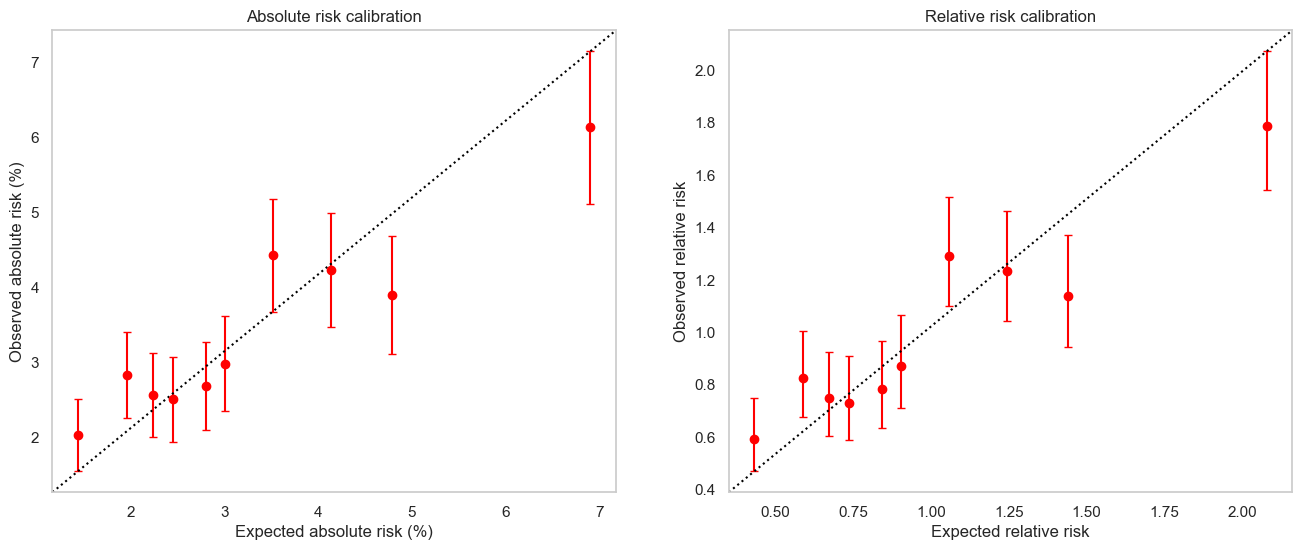

In [29]:
observed_absolute_risk_pct = category_specific_calibration['observed_absolute_risk'] * 100
lower_ci_absolute_risk_pct = category_specific_calibration['lower_ci_absolute_risk'] * 100
upper_ci_absolute_risk_pct = category_specific_calibration['upper_ci_absolute_risk'] * 100
predicted_absolute_risk_pct = category_specific_calibration['predicted_absolute_risk'] * 100

observed_relative_risk = category_specific_calibration['observed_relative_risk']
lower_ci_relative_risk = category_specific_calibration['lower_ci_relative_risk']
upper_ci_relative_risk = category_specific_calibration['upper_ci_relative_risk']
predicted_relative_risk = category_specific_calibration['predicted_relative_risk']

yerr_ar = [observed_absolute_risk_pct - lower_ci_absolute_risk_pct, upper_ci_absolute_risk_pct - observed_absolute_risk_pct]
yerr_rr = [observed_relative_risk - lower_ci_relative_risk, upper_ci_relative_risk - observed_relative_risk]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.set_facecolor('white')
ax2.set_facecolor('white')

ax1.errorbar(predicted_absolute_risk_pct, observed_absolute_risk_pct, yerr=yerr_ar, fmt='o', color='red', capsize=3)
ax1.plot([0, 1], [0, 1], transform=ax1.transAxes, color='black', linestyle='dotted')

ax1.set_xlabel('Expected absolute risk (%)')
ax1.set_ylabel('Observed absolute risk (%)')
ax1.set_title('Absolute risk calibration')

ax2.errorbar(predicted_relative_risk, observed_relative_risk, yerr=yerr_rr, fmt='o', color='red', capsize=3)
ax2.plot([0, 1], [0, 1], transform=ax2.transAxes, color='black', linestyle='dotted')

ax2.set_xlabel('Expected relative risk')
ax2.set_ylabel('Observed relative risk')
ax2.set_title('Relative risk calibration')

plt.show()

Plot discrimination density plots.

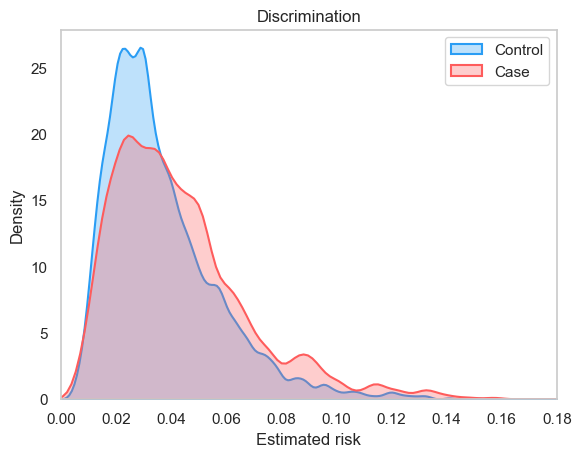

In [30]:
sns.kdeplot(study_data.loc[study_data['observed_outcome'] == 0, 'risk_estimates'], bw_adjust=0.5, color=(42/255, 157/255, 244/255), fill=True, alpha=0.3, linewidth=1.5, label="Control")

sns.kdeplot(study_data.loc[study_data['observed_outcome'] == 1, 'risk_estimates'], bw_adjust=0.5, color=(254/255, 92/255, 92/255), fill=True, alpha=0.3, linewidth=1.5, label="Case")

plt.xlim(0.0, 0.18)
plt.xlabel("Estimated risk")
plt.ylabel("Density")
plt.title("Discrimination")
plt.legend()

plt.show()

Plot the age-specific incidence rates.

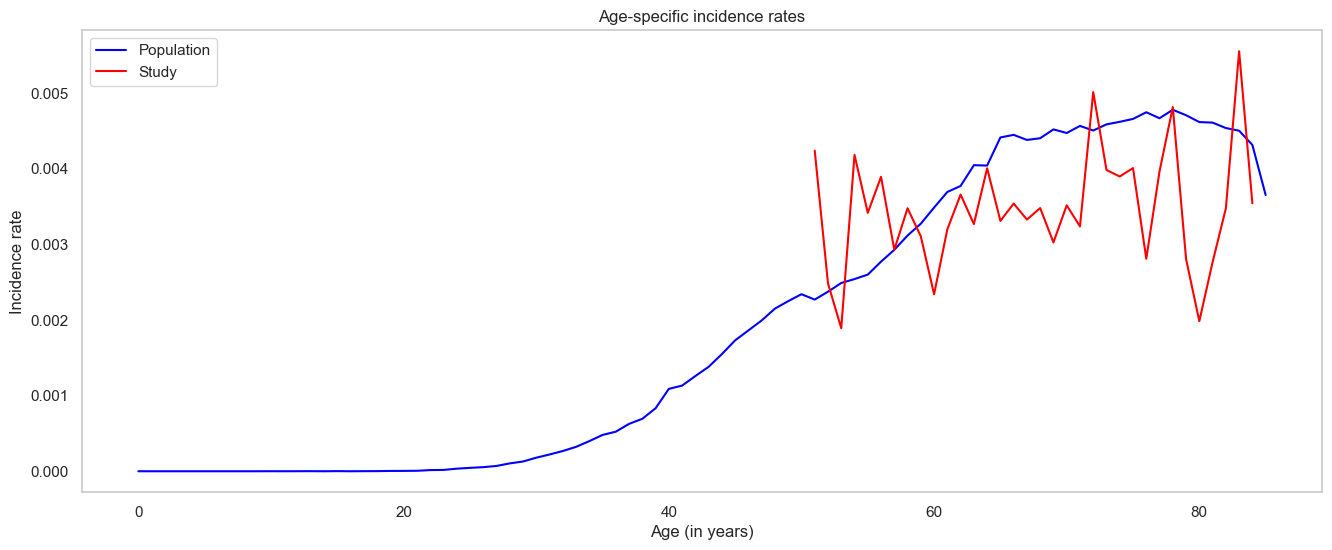

In [31]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.set_facecolor('white')

ax.plot(incidence_rates.index, incidence_rates['population_rate'], color='blue', label='Population')
ax.plot(incidence_rates.index, incidence_rates['study_rate'], color='red', label='Study')

ax.set_xlabel('Age (in years)')
ax.set_ylabel('Incidence rate')
ax.set_title('Age-specific incidence rates')
ax.legend()

plt.show()